In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from scipy.stats import zscore

# Load your cleaned dataset
data = pd.read_csv('merged_data_weathersolar.csv')

# Drop the non-numeric columns that are not needed for anomaly detection
data_for_detection = data.drop(columns=['LOCATION', 'DATE_TIME', 'SENSOR_ID'])

# Fill missing values (if any, but your data shows no missing values)
data_for_detection = data_for_detection.fillna(data_for_detection.mean())

# Scale the data (important for distance-based methods like DBSCAN and Isolation Forest)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_detection)

# 1. **Z-Score Anomaly Detection**
# Z-Score for anomaly detection
z_scores = np.abs(zscore(data_scaled))  # Calculate Z-scores for the scaled data

# Set a threshold for Z-Score (e.g., 3 standard deviations)
threshold = 3
anomalies_zscore = (z_scores > threshold).all(axis=1)  # Anomalies where z-score > threshold

# Add the Z-Score anomaly result to the original data
data['zscore_anomaly'] = anomalies_zscore

# 2. **Isolation Forest Anomaly Detection**
# Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.05)  # Set contamination rate (adjust as needed)

# Fit the model on the scaled data
data['isolation_forest_anomaly'] = isolation_forest.fit_predict(data_scaled)

# Convert the results from {-1, 1} to {True, False} for easier interpretation
data['isolation_forest_anomaly'] = data['isolation_forest_anomaly'] == -1

# 3. **DBSCAN Anomaly Detection**
# DBSCAN for anomaly detection
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed

# Fit the model on the scaled data
data['dbscan_anomaly'] = dbscan.fit_predict(data_scaled)

# DBSCAN labels points as -1 (noise) for anomalies, and 0 or higher for normal points
data['dbscan_anomaly'] = data['dbscan_anomaly'] == -1

# 4. **Combine Results**
# Combine the results from all anomaly detection methods
data['any_anomaly'] = data[['zscore_anomaly', 'isolation_forest_anomaly', 'dbscan_anomaly']].any(axis=1)

# Display rows flagged as anomalies by at least one method
print(data[data['any_anomaly'] == True].head())

# Optionally, you can save the results to a new CSV file for further analysis
# data.to_csv('anomaly_detection_results.csv', index=False)


     LOCATION            DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
815         A  2020-05-15 09:15:00            27.988362           46.617706   
4879        A  2020-05-17 11:15:00            31.531130           60.208570   
4880        A  2020-05-17 11:15:00            31.531130           60.208570   
4881        A  2020-05-17 11:15:00            31.531130           60.208570   
4882        A  2020-05-17 11:15:00            31.531130           60.208570   

      IRRADIATION  SENSOR_ID     DC_POWER     AC_POWER  DAILY_YIELD  \
815      0.344884  sensor 44      0.00000     0.000000   711.000000   
4879     0.997904   sensor 2  12995.50000  1267.075000  3265.500000   
4880     0.997904   sensor 3  12974.00000  1264.950000  3272.250000   
4881     0.997904   sensor 5  12680.87500  1236.375000  3100.750000   
4882     0.997904  sensor 12  13192.42857  1286.271429  3153.714286   

      TOTAL_YIELD  zscore_anomaly  isolation_forest_anomaly  dbscan_anomaly  \
815   7116862.000  

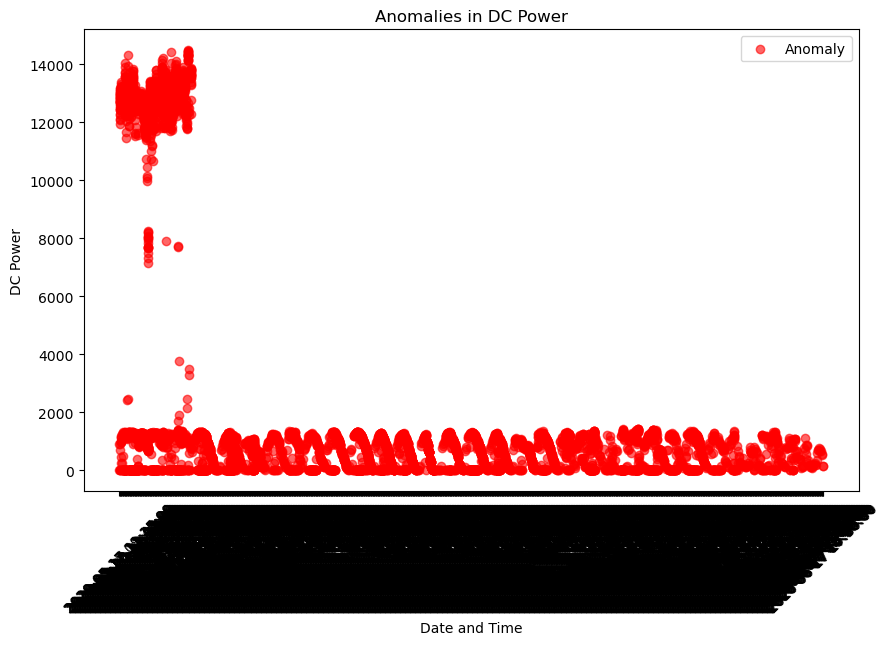

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot anomalies over time for one feature (e.g., DC_POWER)
anomaly_data = data[data['any_anomaly'] == True]

plt.figure(figsize=(10, 6))
plt.scatter(anomaly_data['DATE_TIME'], anomaly_data['DC_POWER'], color='red', label='Anomaly', alpha=0.6)
plt.xlabel('Date and Time')
plt.ylabel('DC Power')
plt.title('Anomalies in DC Power')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [3]:
# Show rows with anomalies
anomalies = data[data['any_anomaly'] == True]
print(anomalies.head())


     LOCATION            DATE_TIME  AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  \
815         A  2020-05-15 09:15:00            27.988362           46.617706   
4879        A  2020-05-17 11:15:00            31.531130           60.208570   
4880        A  2020-05-17 11:15:00            31.531130           60.208570   
4881        A  2020-05-17 11:15:00            31.531130           60.208570   
4882        A  2020-05-17 11:15:00            31.531130           60.208570   

      IRRADIATION  SENSOR_ID     DC_POWER     AC_POWER  DAILY_YIELD  \
815      0.344884  sensor 44      0.00000     0.000000   711.000000   
4879     0.997904   sensor 2  12995.50000  1267.075000  3265.500000   
4880     0.997904   sensor 3  12974.00000  1264.950000  3272.250000   
4881     0.997904   sensor 5  12680.87500  1236.375000  3100.750000   
4882     0.997904  sensor 12  13192.42857  1286.271429  3153.714286   

      TOTAL_YIELD  zscore_anomaly  isolation_forest_anomaly  dbscan_anomaly  \
815   7116862.000  

In [4]:
# Save the results to a CSV file
data.to_csv('anomalies_detected.csv', index=False)


In [6]:
import pandas as pd

# Load the anomalies detected dataset
data = pd.read_csv('anomalies_detected.csv')

# Count the number of anomalies where 'any_anomaly' is True
anomaly_count = data[data['any_anomaly'] == True].shape[0]

# Display the count of anomalies
print(f'Number of anomalies detected: {anomaly_count}')


Number of anomalies detected: 6971
